# AWD-LSTM (no pretraining)

In this notebook we train an AWD-LSTM model for the proxy task without any language model pretraining.  This notebook has been adapted from the fast.ai [ULMFit tutorial](https://github.com/fastai/course-nlp/blob/master/nn-vietnamese.ipynb).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.text import *
import glob
import eval_models

In [2]:
bs=48

In [3]:
torch.cuda.set_device(0)

In [4]:
data_path = Config.data_path()

In [5]:
name = 'solo_bscore_lm'
path = data_path/name
path.mkdir(exist_ok=True, parents=True)

### Train Classifier

In [6]:
train_df = pd.read_csv(path/'train256.csv')
valid_df = pd.read_csv(path/'valid256.csv')
test_df = pd.read_csv(path/'test256.csv')

In [7]:
basicTokenizer = Tokenizer(pre_rules=[], post_rules=[])
data_clas = TextDataBunch.from_df(path, train_df, valid_df, tokenizer=basicTokenizer, bs=bs, num_workers=1)

In [8]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, pretrained=False, drop_mult=0.5, 
                                  metrics=[accuracy, FBeta(average='macro', beta=1)])

In [62]:
learn_c.lr_find()

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 6.31E-04


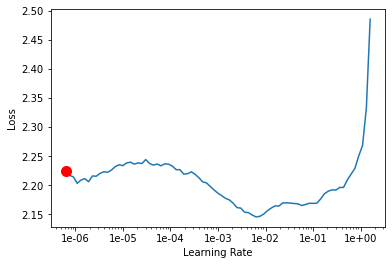

In [63]:
learn_c.recorder.plot(suggestion=True)

In [77]:
lr = 3e-4

In [78]:
learn_c.fit_one_cycle(4, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.311549,1.641021,0.423715,0.393568,04:13
1,0.870595,1.467136,0.515833,0.493579,04:17
2,0.621346,1.431927,0.540486,0.535586,04:17
3,0.537617,1.457092,0.542674,0.538425,04:18


In [10]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True, parents=True)

In [79]:
learn_c.save(mdl_path/'awdlstm_clas_256')

In [12]:
learn_c = learn_c.load(mdl_path/'awdlstm_clas_256')

### Evaluate Classifier

Evaluate on the proxy task -- classifying fixed-length chunks of bootleg score features.

In [80]:
data_clas_test = TextDataBunch.from_df(path, train_df, test_df, tokenizer=basicTokenizer, bs=bs, num_workers=1)

In [84]:
learn_c.validate(data_clas_test.valid_dl)

KeyboardInterrupt: 

Evaluate on the original task -- classifying pages of sheet music.  We can evaluate our models in two ways:
- applying the model to a variable length sequence
- applying the model to multiple fixed-length windows and averaging the predictions

First we evaluate the model on variable length inputs.  Report results with and without applying priors.

In [15]:
train_fullpage_df = pd.read_csv(path/'train.fullpage.csv')
valid_fullpage_df = pd.read_csv(path/'valid.fullpage.csv')
test_fullpage_df = pd.read_csv(path/'test.fullpage.csv')

In [ ]:
(acc, acc_with_prior), (f1, f1_with_prior) = eval_models.calcAccuracy_fullpage(learn_c, path, train_fullpage_df, valid_fullpage_df, test_fullpage_df)
(acc, acc_with_prior), (f1, f1_with_prior)

Now we evaluate the model by considering multiple fixed-length windows and averaging the predictions.

In [13]:
test_ensemble_df = pd.read_csv(path/'test.ensemble256.csv')

In [16]:
(acc, acc_with_prior), (f1, f1_with_prior) = eval_models.calcAccuracy_fullpage(learn_c, path, train_fullpage_df, valid_fullpage_df, test_ensemble_df, ensembled=True)
(acc, acc_with_prior), (f1, f1_with_prior)

((0.4954721927642822, 0.49935317039489746),
 (0.4534919536567773, 0.43807646644158516))

### Error Analysis

In [11]:
interp = ClassificationInterpretation.from_learner(learn_c)

In [12]:
mat = interp.confusion_matrix()

In [6]:
import seaborn as sns

In [ ]:
# plucked string

In [7]:
mat = [[854, 162, 33, 151], 
       [122, 1228, 174, 1309],
       [42, 244, 440, 474],
       [129, 744, 269, 1354]]

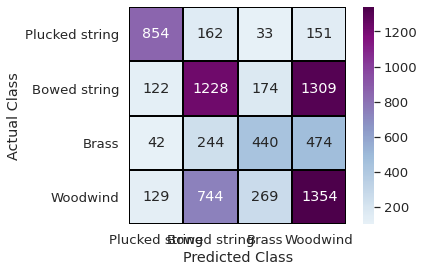

In [22]:
midpoint = (np.amax(mat) - np.amin(mat)) // 2
# sns.set(font_scale=1.2)
h = sns.heatmap(mat, 
            annot=True, 
            fmt="d", 
            cmap='BuPu', 
            center=midpoint, 
            vmin=100, 
            robust=True,
            linewidths=1, linecolor='black',
            square=True)
plt.yticks(rotation=0) 
h.set_xticklabels(['Plucked string', 'Bowed string', 'Brass', "Woodwind"])
h.set_yticklabels(['Plucked string', 'Bowed string', 'Brass', "Woodwind"])
h.set(xlabel="Predicted Class", ylabel="Actual Class")


In [ ]:
sns.set(font_scale=1.6)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_c)
mat = interp.confusion_matrix()

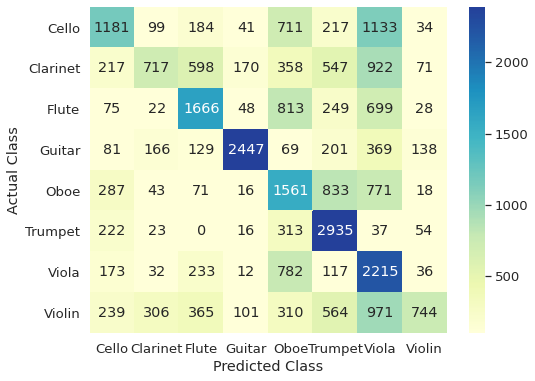

In [77]:
import seaborn as sns
midpoint = (np.amax(mat) - np.amin(mat)) // 2
# interp = ClassificationInterpretation.from_learner(learn_c)
# mat = interp.confusion_matrix()
plt.figure(figsize=(8, 6))
h = sns.heatmap(mat, 
            annot=True, 
            fmt="d", 
            cmap='YlGnBu', 
            center=midpoint, 
            vmin=100, 
            robust=True)
plt.yticks(rotation=0)
h.set_xticklabels(['Cello','Clarinet','Flute','Guitar','Oboe','Trumpet','Viola','Violin'])
h.set_yticklabels(['Cello','Clarinet','Flute','Guitar','Oboe','Trumpet','Viola','Violin'])
h.set(xlabel="Predicted Class", ylabel="Actual Class")
plt.savefig('confusion_matrix.png', dpi=300)

[Text(76.5, 0.5, 'Actual Class'),
 Text(0.5, 62.459999999999965, 'Predicted Class')]

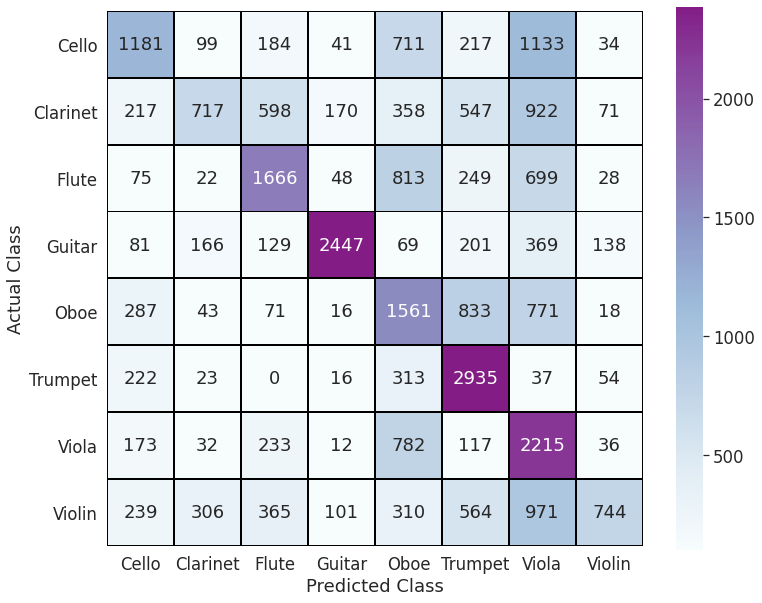

In [167]:
plt.figure(figsize=(12, 10))
h = sns.heatmap(mat, 
            annot=True, 
            fmt="d", 
            cmap='BuPu', 
            center=midpoint, 
            vmin=100, 
            robust=True,
            linewidths=1, linecolor='black',
            square=True)
plt.yticks(rotation=0) 
h.set_xticklabels(['Cello','Clarinet','Flute','Guitar','Oboe','Trumpet','Viola','Violin'])
h.set_yticklabels(['Cello','Clarinet','Flute','Guitar','Oboe','Trumpet','Viola','Violin'])
h.set(xlabel="Predicted Class", ylabel="Actual Class")

[Text(76.5, 0.5, 'Actual Class'),
 Text(0.5, 62.459999999999965, 'Predicted Class')]

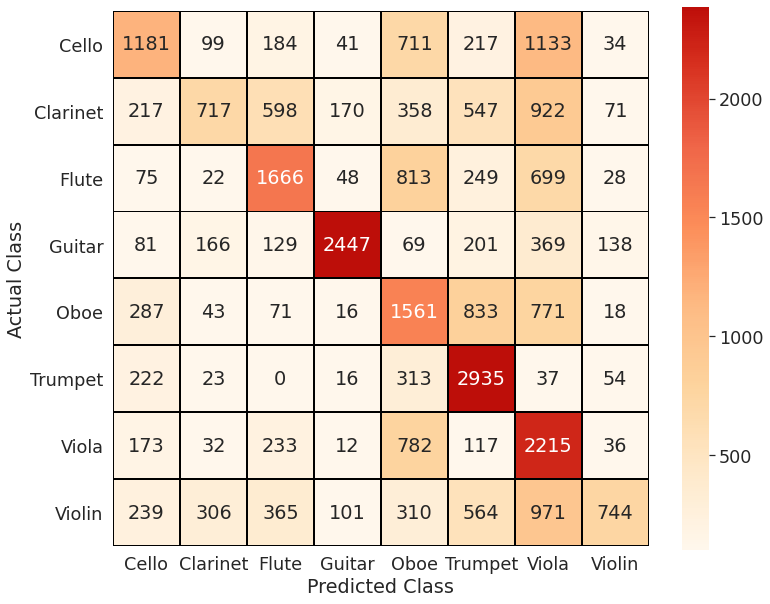

In [178]:
plt.figure(figsize=(12, 10))
h = sns.heatmap(mat, 
            annot=True, 
            fmt="d", 
            cmap='OrRd', 
            center=midpoint, 
            vmin=100, 
            robust=True,
            linewidths=1, linecolor='black',
            square=True)
plt.yticks(rotation=0) 
h.set_xticklabels(['Cello','Clarinet','Flute','Guitar','Oboe','Trumpet','Viola','Violin'])
h.set_yticklabels(['Cello','Clarinet','Flute','Guitar','Oboe','Trumpet','Viola','Violin'])
h.set(xlabel="Predicted Class", ylabel="Actual Class")

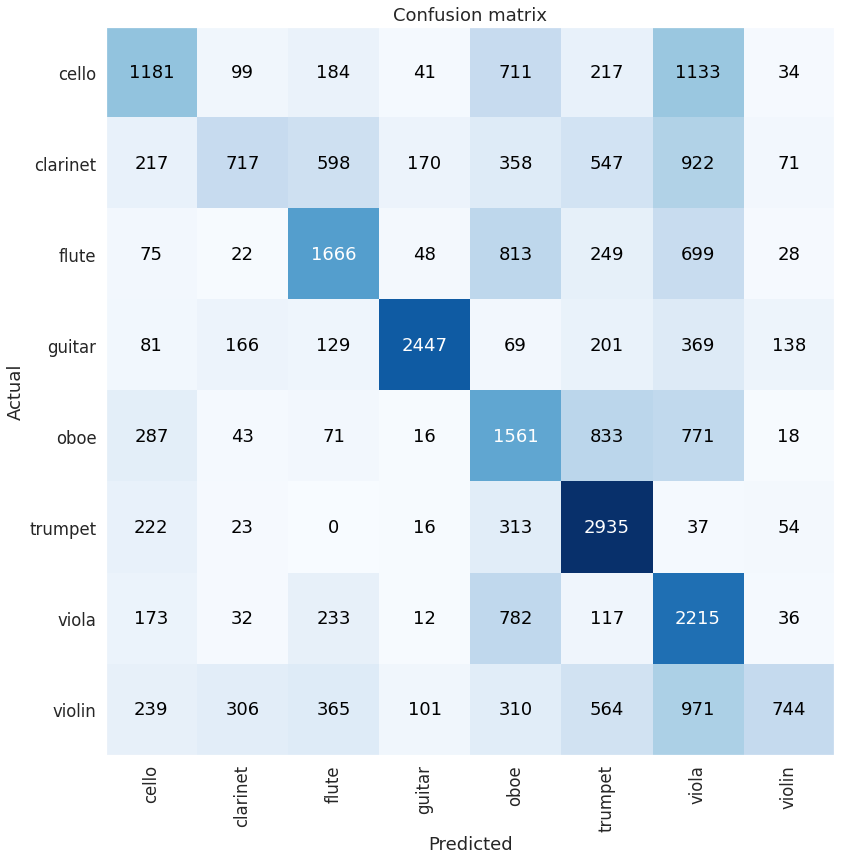

In [133]:
interp.plot_confusion_matrix(figsize=(12,12))